In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


In [3]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.loc[df['close'] == 1, 'price_am'] = 0
df.loc[df['close'] == 1, 'price_pm'] = 0
df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,NaN,NaN
1,2010-07-02,18.0,0,0,NaN,NaN
2,2010-07-03,20.0,0,0,NaN,NaN
3,2010-07-04,20.0,0,0,NaN,NaN
4,2010-07-05,14.0,0,0,NaN,NaN


In [4]:
### datimeをdatetime64[ns]型に変更。

In [5]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [6]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

### Fill na

In [7]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

### New features

In [8]:
df['price'] = (df['price_am'] + df['price_pm'])/2

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         2101 non-null   float64
 1   client    2466 non-null   int64  
 2   close     2466 non-null   int64  
 3   price_am  2466 non-null   float64
 4   price_pm  2466 non-null   float64
 5   year      2466 non-null   int64  
 6   month     2466 non-null   int64  
 7   day       2466 non-null   int64  
 8   weekday   2466 non-null   int64  
 9   price     2466 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 211.9 KB


In [10]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)

In [11]:
pd.set_option('display.max_rows', None)
print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
print(df.groupby(['year'])['price_am','price_pm','y'].mean())

               price_am  price_pm          y
month weekday                               
1     0        0.129032  0.000000  23.423077
      1        0.096774  0.064516  21.846154
      2        0.033333  0.000000  22.692308
      3        0.161290  0.096774  21.296296
      4        0.258065  0.161290  27.444444
      5        0.806452  0.419355  36.296296
      6        0.375000  0.218750  32.666667
10    0        0.518519  0.192308  28.538462
      1        0.192308  0.076923  25.769231
      2        0.185185  0.074074  28.148148
      3        0.222222  0.148148  29.481481
      4        0.500000  0.269231  32.222222
      5        1.629630  1.111111  39.000000
      6        1.346154  0.730769  35.269231
11    0        0.120000  0.040000  28.576923
      1        0.153846  0.076923  24.000000
      2        0.153846  0.076923  24.280000
      3        0.160000  0.080000  26.120000
      4        0.423077  0.269231  32.269231
      5        1.423077  1.000000  38.884615
      6   

<ipython-input-11-ab1e28b0b82f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
<ipython-input-11-ab1e28b0b82f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['year'])['price_am','price_pm','y'].mean())


In [12]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'month', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'year', 'day', 'price']


### Pandas Profining

In [13]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

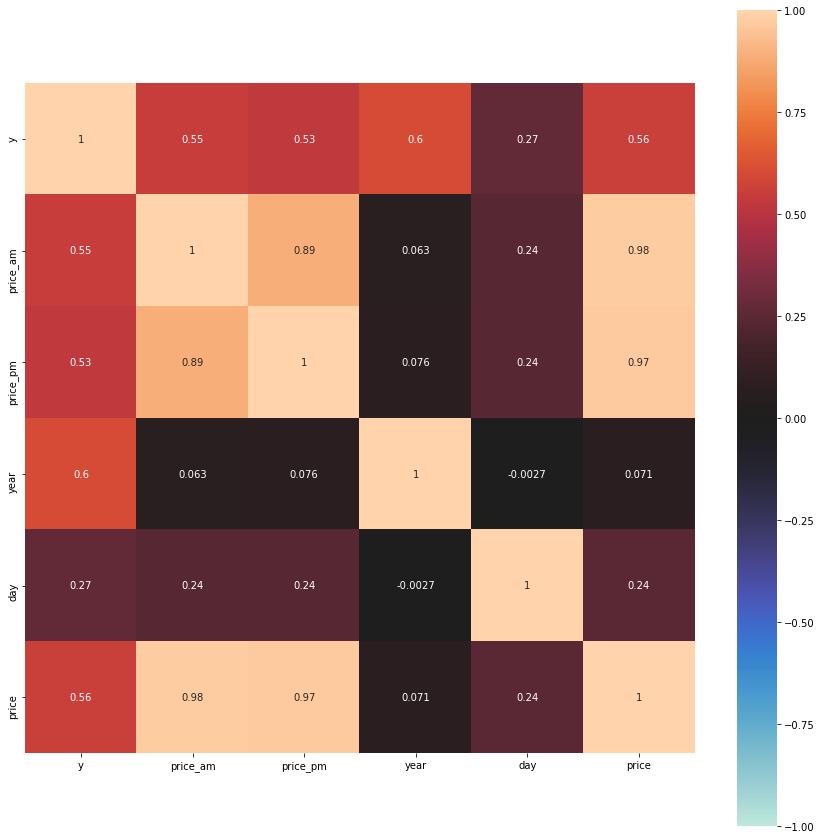

In [14]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


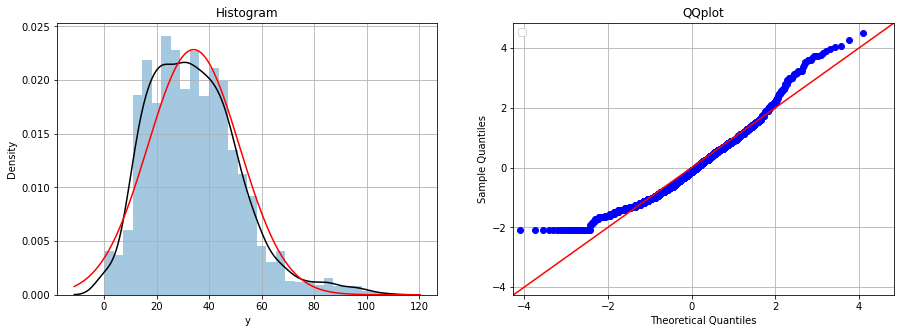

In [15]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Dummy

In [16]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [17]:
df.head(10)

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,14.0,0.333333,0.148148,2010,6,0.240741,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
6,4.0,0.259259,0.111111,2010,7,0.185185,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7,10.0,0.192308,0.076923,2010,8,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
8,12.0,0.692308,0.423077,2010,9,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9,21.0,1.807692,1.192308,2010,10,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### Separate Data

In [18]:
train = df[:len(train)]
test = df[len(train):]

In [19]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [20]:
### 線形回帰

In [21]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          2101 non-null   float64
 1   price_am   2466 non-null   float64
 2   price_pm   2466 non-null   float64
 3   year       2466 non-null   int64  
 4   day        2466 non-null   int64  
 5   price      2466 non-null   float64
 6   client_1   2466 non-null   uint8  
 7   close_1    2466 non-null   uint8  
 8   month_10   2466 non-null   uint8  
 9   month_11   2466 non-null   uint8  
 10  month_12   2466 non-null   uint8  
 11  month_2    2466 non-null   uint8  
 12  month_3    2466 non-null   uint8  
 13  month_4    2466 non-null   uint8  
 14  month_5    2466 non-null   uint8  
 15  month_6    2466 non-null   uint8  
 16  month_7    2466 non-null   uint8  
 17  month_8    2466 non-null   uint8  
 18  month_9    2466 non-null   uint8  
 19  weekday_1  2466 non-null   uint8  
 20  weekday_2

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
# データセットの標準化準備
scaler= StandardScaler()
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)


In [24]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

{'alpha': 0.025118864315094896}
R^2 = 0.7394474182666277
MAE = 6.866211410897769


In [25]:
#X_train['pred'] = y_lasso_pred
#X_test['pred'] = y_lasso_test_pred
## データセットの標準化
#scaler.fit(X_train)
#scaler.fit(X_test)
#X_train_scaler = scaler.transform(X_train)
#X_test_scaler  = scaler.transform(X_test)

In [26]:
#import optuna.integration.lightgbm as lgb # Optuna 
import lightgbm as lgb 
from sklearn.model_selection import KFold

In [52]:
def SVC_fit(random_sts):
    scaler.fit(X_train)
    scaler.fit(X_test)
    X_train_scaler = scaler.transform(X_train)
    X_test_scaler  = scaler.transform(X_test)
    # SVM
    params_grid = [
        {'C': [1, 10], 'kernel':['linear']},
        {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
    ]
    # パラメータチューニング
    clf = GridSearchCV(
        estimator = SVC(),
        param_grid = params_grid,
        cv = 5,
        scoring='r2',
        n_jobs = -1
        )

    # フィッテイング
    clf.fit(X_train_scaler, y_train) 

    # チューニングしたモデル
    best_param = clf.best_params_
    svc_tuned = clf.best_estimator_

    # 予測値を反映
    y_svc_pred = svc_tuned.predict(X_train_scaler) # Trainデータに対して予測
    y_svc_test_pred = svc_tuned.predict(X_test_scaler) # Testデータに対して予測

    print(best_param)
    print("Score = {}".format(clf.score(X_train_scaler, y_train)))
    print("MAE = {}".format(mean_absolute_error(y_train, y_svc_pred)))
    mae_result = mean_absolute_error(y_train, y_svc_pred)
    
    X_train['pred'] = y_svc_pred
    X_test['pred'] = y_svc_test_pred
    # データセットの標準化
    scaler.fit(X_train)
    scaler.fit(X_test)
    X_train_scaler = scaler.transform(X_train)
    X_test_scaler  = scaler.transform(X_test)
    return y_svc_pred, y_svc_test_pred, mae_result
    

In [53]:
def lightGBM_fit(random_sts):
    y_lgb_preds = []
    models = []
    y_lgb_oof_train = np.zeros((len(X_train),))
    cv = KFold(n_splits=5, shuffle=True, random_state=random_sts)

    params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective': 'regression',
        'metric' : 'rmse',
        'max_bin' : 255,
        'num_leaves' : 31,
        'learning_rate' : 0.05,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : -1
    }

    # Cross Validation
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.iloc[train_index, :]
        X_val = X_train.iloc[valid_index, :]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[valid_index]
    
        # Train Dataset
        lgb_train = lgb.Dataset(X_tr, y_tr)

        # Evaluation Dataset (early_stopping_rounds)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
        evals_result = {} #結果を格納するための辞書
        # train
        gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
        # Out-of-hold of train data
        y_lgb_oof_train[valid_index] = \
            gbm.predict(X_val, num_iteration=gbm.best_iteration)

    
        # Prediction for X_test data
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
        # Append Prediction data 
        y_lgb_preds.append(y_pred)
        models.append(gbm)

    mae_result = mean_absolute_error(y_train, y_lgb_oof_train)
    print("MAE = {}".format(mae_result))
    
    X_train['pred'] = y_svc_pred
    X_test['pred'] = y_svc_test_pred
    # データセットの標準化
    scaler.fit(X_train)
    scaler.fit(X_test)
    X_train_scaler = scaler.transform(X_train)
    X_test_scaler  = scaler.transform(X_test)
    return y_lgb_oof_train, y_lgb_preds, mae_result

In [54]:
svc_mae_result = []
lgb_mae_result = []
for i in range(0,5):
    y_svc_pred, y_svc_test_pred,mae_result = SVC_fit(i)
    svc_mae_result.append(mae_result)
    print(X_train.tail())
    y_lgb_oof_train, y_lgb_preds, mae_result = lightGBM_fit(i)
    lgb_mae_result.append(mae_result)
    print(X_train.tail())

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Score = 0.7986168517136314
MAE = 4.963826749167064
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_7  month_8  month_9  weekday_1  \
2096         0         0  ...        0        0        0          0   
2097         0         0  ...        0        0        0          0   
2098         0         0  ...        0        0        0          1   
2099         0         0  ...        0        0        0          0   
2100         0         0  ...        0        0        0          0   

      weekday_2  weekday_3  w

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Score = 0.7996006688018741
MAE = 4.9614469300333175
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_7  month_8  month_9  weekday_1  \
2096         0         0  ...        0        0        0          0   
2097         0         0  ...        0        0        0          0   
2098         0         0  ...        0        0        0          1   
2099         0         0  ...        0        0        0          0   
2100         0         0  ...        0        0        0          0   

      weekday_2  weekday_3  

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Score = 0.7987415828817128
MAE = 4.958115183246074
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_7  month_8  month_9  weekday_1  \
2096         0         0  ...        0        0        0          0   
2097         0         0  ...        0        0        0          0   
2098         0         0  ...        0        0        0          1   
2099         0         0  ...        0        0        0          0   
2100         0         0  ...        0        0        0          0   

      weekday_2  weekday_3  w

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Score = 0.7995289483802273
MAE = 4.962398857686816
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_7  month_8  month_9  weekday_1  \
2096         0         0  ...        0        0        0          0   
2097         0         0  ...        0        0        0          0   
2098         0         0  ...        0        0        0          1   
2099         0         0  ...        0        0        0          0   
2100         0         0  ...        0        0        0          0   

      weekday_2  weekday_3  w

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Score = 0.7987026043916874
MAE = 4.9614469300333175
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_7  month_8  month_9  weekday_1  \
2096         0         0  ...        0        0        0          0   
2097         0         0  ...        0        0        0          0   
2098         0         0  ...        0        0        0          1   
2099         0         0  ...        0        0        0          0   
2100         0         0  ...        0        0        0          0   

      weekday_2  weekday_3  

In [55]:
print(svc_mae_result)
print(lgb_mae_result)

[4.963826749167064, 4.9614469300333175, 4.958115183246074, 4.962398857686816, 4.9614469300333175]
[4.821649825548415, 4.771630103464724, 4.8381302782870605, 4.842005928448605, 4.750177907285698]


In [ ]:
X_train['pred'] = y_svc_pred
X_test['pred'] = y_svc_test_pred
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [ ]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

In [ ]:
#X_train['pred'] = y_ridge_pred
#X_test['pred'] = y_ridge_test_pred
## データセットの標準化
#scaler.fit(X_train)
#scaler.fit(X_test)
#X_train_scaler = scaler.transform(X_train)
#X_test_scaler  = scaler.transform(X_test)

In [ ]:
lightGBM_fit()

In [ ]:
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['eval']['rmse']
train_metric[:5], eval_metric[:5]

In [ ]:
plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.ylim(0, 10)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.grid(True)
plt.show()

In [ ]:
y_total_pred = y_lasso_pred*0.0 + y_ridge_pred*0.0 + y_svc_pred*0.0 + y_lgb_oof_train*1.0

In [ ]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
plt.scatter(y_train, y_lgb_oof_train)
plt.scatter(y_train, y_total_pred)



plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
result_mae = mean_absolute_error(y_train, y_total_pred)
#result_mae = mean_absolute_error(y_train, y_lgb_oof_train)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [ ]:
# Average of Prediction data (LightGBM)
y_lgb_test_pred = sum(y_lgb_preds)/len(y_lgb_preds)

In [ ]:
submit_sample[1] = y_lgb_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [ ]:
submit_sample.head()